# Image classification with Convolutional Neural Networks for DefectNET data set v4.1  from DJ


In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import torch
from fastai.imports import *
import pandas as pd
import glob2 as glob

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/DefectNet/"
print (PATH)
!ls {PATH}

data/DefectNet/
labels2v40.csv	labels2v41.csv	labelsv40.csv  labelsv41.csv  test  tmp  train


In [ ]:
!fdupes -r ~/data/DefectNet/train/

In [5]:
sz=64
arch = resnet50
bs=24

In [6]:
label_csv = f'{PATH}/test/labels.csv'
!ls {PATH}/train

allover  band_od	  halfmoon	scattered      spokes  thumb
band_id  clean		  inside_thumb	shaded	       spot
band_md  dense_scattered  nonopscratch	spiralscratch  target


from SHUBHAM24 in Deep Learning Part I v2 course

run only next cell if PNG files are in their respective directories

In [7]:
# update from Kaggel Comp:  Plant Seedlings post
df = pd.DataFrame(columns=["file", "defect"])

for image in glob("data/DefectNet/train/**/*.png"):
    dir_ = image.split('/')
    file_, defect = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "defect": defect.replace(" ", "_")
        }, ignore_index=True)
df.to_csv('data/DefectNet/labelsv41.csv', index=False)

In [8]:
!ls {PATH}

labels2v40.csv	labels2v41.csv	labelsv40.csv  labelsv41.csv  test  tmp  train


In [9]:
df[:5]

,file,defect
0,1DGBWTVZ-11-20171117131450.png.crop.png,spokes
1,1DGBZ9LZ-01-20171118023826.png.crop.png,spokes
2,8DG9VJZD-15-20171103034147.png.crop.png,spokes
3,06JD753B-05-20171101213937.png.crop.png,spokes
4,8DGA96ZD-04-20171103174743.png.crop.png,spokes


In [ ]:
label_csv = f'{PATH}labels2.csv'
!ls {PATH}

do the same for TEST dataset

In [10]:
df = pd.DataFrame(columns=["file", "defect"])

for image in glob("data/DefectNet/test/**/*.png"):
    dir_ = image.split('/')
    file_, defect = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "defect": defect.replace(" ", "_")
        }, ignore_index=True)
df.to_csv('data/DefectNet/labels2v41.csv', index=False)

In [13]:
!ls {PATH}

labels2v41.csv	labelsv41.csv  test  tmp  train


In [12]:
df[:5]

,file,defect
0,1SHP3RNZ-03-20171117001811.png.crop.png,spokes
1,1SHPXMUZ-02-20171117071801.png.crop.png,spokes
2,8DG9XUDD-00-20171101094010.png.crop.png,spokes
3,1SHRD20Z-00-20171117061004.png.crop.png,spokes
4,1DGBV8LZ-01-20171117110718.png.crop.png,spokes


In [14]:
label_csv = f'{PATH}labelsv41.csv'
!ls {PATH}

labels2v41.csv	labelsv41.csv  test  tmp  train


In [15]:
#list of rows, minus 1, nubmer of rows in CSV, number of imgs
n = len(list(open(label_csv)))-1
print(n)

5620


In [16]:
sz=372
arch = resnet50
bs=64

In [17]:
#get crossvalidation indexes custom FASTAI
val_idxs = get_cv_idxs(n)
n

5620

In [18]:
val_idxs

array([4122, 3074,   80, ..., 2513,  533, 3540])

In [19]:
??get_cv_idxs

In [20]:
def get_cv_idxs(n, cv_idx=4, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

    Initial Exploration

In [21]:
label_df = pd.read_csv(label_csv)

In [22]:
label_df.head()

,file,defect
0,1DGBWTVZ-11-20171117131450.png.crop.png,spokes
1,1DGBZ9LZ-01-20171118023826.png.crop.png,spokes
2,8DG9VJZD-15-20171103034147.png.crop.png,spokes
3,06JD753B-05-20171101213937.png.crop.png,spokes
4,8DGA96ZD-04-20171103174743.png.crop.png,spokes


In [23]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labelsv41.csv', test_name='train', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [24]:
fn = PATH + data.trn_ds.fnames[3000]
fn

'data/DefectNet/train/8DA0NK8S-13-20171102182932.png.crop.png'

In [25]:
PATH

'data/DefectNet/'

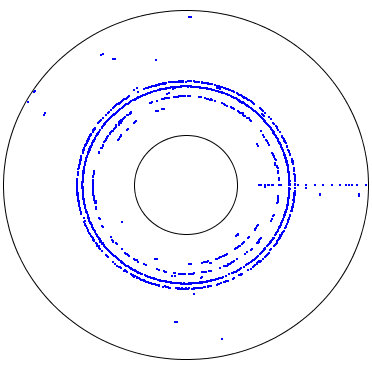

In [26]:
img = PIL.Image.open(fn)
img

In [27]:
img.size

(372, 372)

How big are the images? Most imagenets are trained on 224 x 224 or 299 x 299. Lets make a dictionary comprehension to store all the names of the files to the size of the files. This will be important for memory and size consideration

In [28]:
print (len(('data/DefectNet/train/**')))

23


In [29]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [30]:
row_sz, col_sz = list(zip(*size_d.values()))

In [31]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

In [32]:
row_sz[:5]

array([372, 372, 372, 372, 372])

(array([   0.,    0.,    0.,    0.,    0., 4496.,    0.,    0.,    0.,    0.]),
 array([371.5, 371.6, 371.7, 371.8, 371.9, 372. , 372.1, 372.2, 372.3, 372.4, 372.5]),
 <a list of 10 Patch objects>)

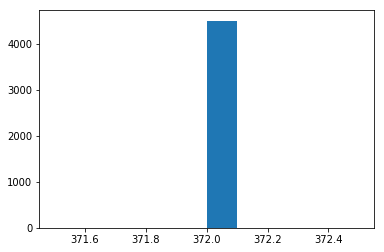

In [33]:
plt.hist(row_sz)

(array([   0.,    0.,    0.,    0.,    0., 4496.,    0.,    0.,    0.,    0.]),
 array([371.5, 371.6, 371.7, 371.8, 371.9, 372. , 372.1, 372.2, 372.3, 372.4, 372.5]),
 <a list of 10 Patch objects>)

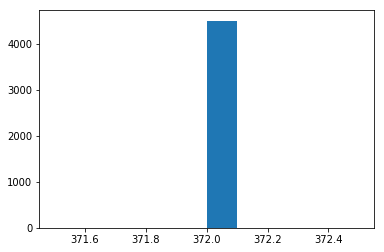

In [34]:
plt.hist(row_sz[row_sz<1000]) 

(array([   0.,    0.,    0.,    0.,    0., 4496.,    0.,    0.,    0.,    0.]),
 array([371.5, 371.6, 371.7, 371.8, 371.9, 372. , 372.1, 372.2, 372.3, 372.4, 372.5]),
 <a list of 10 Patch objects>)

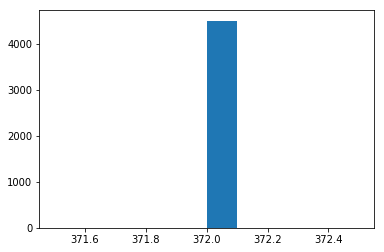

In [35]:
plt.hist(col_sz)

In [36]:
len(data.trn_ds), len(data.test_ds)

(4496, 5620)

## Initial Model

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [ ]:
??get_cv_idxs
??ConvLearner

In [66]:
sz = 327
bs = 64
arch=resnet50
sz, bs, arch

(327, 64, <function torchvision.models.resnet.resnet50>)

In [ ]:
??get_data

In [67]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    #tfms=tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labelsv41.csv', test_name='test', val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 600 else data.resize(327, 'tmp')

In [68]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#tfms=tfms_from_model(arch, sz)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labelsv41.csv', test_name='test', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [69]:
PATH
print (PATH, arch, sz, bs)

data/DefectNet/ <function resnet50 at 0x7f3e89fd2d90> 327 64


In [70]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [71]:
learn = ConvLearner.pretrained(arch, data, ps = 0.5, precompute=True)

100%|██████████| 24/24 [00:28<00:00,  1.17s/it]


In [74]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.61346 0.61083 0.81443]                          


In [75]:
learn.precompute=False

In [76]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.75131 0.65924 0.80141]                          
[1.      0.70969 0.62631 0.80729]                          
[2.      0.69896 0.634   0.80141]                          


In [78]:
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████▏| 65/71 [01:25<00:07,  1.32s/it, loss=3]    

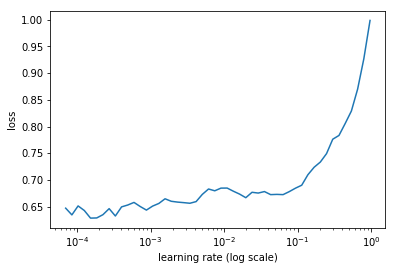

In [79]:
lrf=learn.lr_find()
learn.sched.plot()

In [80]:
lr = 0.05

In [81]:
learn.fit(lr, n_cycle=3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.83955 0.68323 0.79379]                          
[1.      0.81126 0.67746 0.79118]                          
[2.      0.75739 0.6359  0.7988 ]                          


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lr, n_cycle=3, cycle_len=2, cycle_mult=2)

In [ ]:
learn.summary()

In [ ]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

change sz ONLY

In [ ]:
sz =372
bs = 64
sz, bs, arch

In [ ]:
learn.set_data(get_data(372, bs))
learn.freeze()

In [ ]:
learn.fit(0.01, 3, cycle_len=1)

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(0.01, 3, cycle_len=1)

In [ ]:
learn.precompute=True
learn.unfreeze()

In [ ]:
learn.fit(0.01, 3, cycle_len=1)

stop here

In [ ]:
sz, bs

In [ ]:
learn.precompute=False
learn.fit(1e-2, 3, cycle_len =1)

In [ ]:
sz=299
bs=64
data = get_data(sz,bs)
print (sz, bs)

A Jupyter Widget

Used Resnet34 since resnext didn’t load for some errors

In [ ]:
arch=resnext50
data = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, data, ps = [0.70], precompute=True)
learn.fit(0.01, 10)

In [ ]:
sz, bs
learn

In [ ]:
learn.precompute=False
learn.fit(0.01, 5, cycle_len=1)

In [ ]:
print(sz,bs)
learn

In [ ]:
learn.precompute=False
learn.fit(1e-2, 5, cycle_len =1)

In [ ]:
sz =299
bs = 64
data = get_data(sz, bs)
print (sz, bs)

In [ ]:
learn.precompute=True
learn.fit(1e-2,3)

In [ ]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.sched.plot_lr()
learn.fit(lr, 3, cycle_len=1)

In [ ]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

In [ ]:
learn.sched.plot_lr()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

from 

In [ ]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy(preds, y)

In [ ]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

In [ ]:
log_preds_test.shape

In [ ]:
log_preds_test = np.argmax(log_preds_test, axis = 1)
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
probs = np.exp(log_preds_test)

In [ ]:
PATH

In [ ]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv('data/plant_seedlings/subm.gz', compression = 'gzip', index=False)

In [ ]:
submission

In [ ]:
FileLink('data/plant_seedlings/subm.gz')

In [ ]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)
accuracy(probs, y)

In [ ]:
probs[:1]

In [ ]:
probs.shape

In [ ]:
ds = pd.DataFrame(probs)
ds.columns = data.classes

In [ ]:
ds.head()

In [ ]:
ds.replace(10, to_replace='_', value=' ', inplace = True)

In [ ]:
??ds.replace()

In [ ]:
ds.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
ds.head()

In [ ]:
SUBM = f'{PATH}subm.gz'
os.makedirs(SUBM, exist_ok = True)
ds.to_csv(f'{SUBM}subm.gz', compression = 'gzip', index = False)

In [ ]:
FileLink(f'{SUBM}subm.gz')

In [ ]:
submission = pd.DataFrame(preds_classes, os.listdir(f'{PATH}test'))

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

In [ ]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

In [ ]:
learn.freeze()

Below is Dog vs. Cat info

In [ ]:
!ls {PATH}valid

In [ ]:
files = !ls {PATH}valid/cats | head
files

In [ ]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [ ]:
img.shape

In [ ]:
img[:4,:4]

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# !rm -rf {PATH}tmp

In [ ]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

In [ ]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

In [ ]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [ ]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [ ]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [ ]:
ims = np.stack([get_augs() for i in range(6)])

In [ ]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(1e-2, 1)

In [ ]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [ ]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [ ]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [ ]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. *Hyparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [ ]:
learn.fit(1e-2, 1)

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [ ]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [ ]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss is should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.